In [1]:
import datetime
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

2022-06-06 02:42:06.587372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-06 02:42:06.587463: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Import the data
df = pd.read_csv('MSFT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061109,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063292,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064383,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062746,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061655,47894400
...,...,...,...,...,...,...,...
9123,2022-05-23,255.490005,261.500000,253.429993,260.649994,260.649994,33175400
9124,2022-05-24,257.890015,261.329987,253.500000,259.619995,259.619995,29043900
9125,2022-05-25,258.140015,264.579987,257.130005,262.519989,262.519989,28547900
9126,2022-05-26,262.269989,267.109985,261.429993,265.899994,265.899994,25002100


In [3]:
df = df[['Date', 'Close']]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9123,2022-05-23,260.649994
9124,2022-05-24,259.619995
9125,2022-05-25,262.519989
9126,2022-05-26,265.899994


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date']

/tmp/ipykernel_62354/1793818658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9123   2022-05-23
9124   2022-05-24
9125   2022-05-25
9126   2022-05-26
9127   2022-05-27
Name: Date, Length: 9128, dtype: datetime64[ns]

In [5]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2022-05-23,260.649994
2022-05-24,259.619995
2022-05-25,262.519989


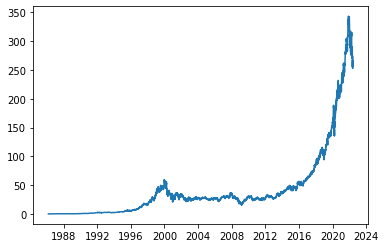

In [6]:
plt.plot(df.index, df['Close'])

In [7]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = pd.to_datetime(first_date_str)
  last_date  = pd.to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df


In [8]:
# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-05-24', 
                                '2022-05-25', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-05-24,243.119995,246.479996,245.169998,250.779999
1,2021-05-25,246.479996,245.169998,250.779999,251.720001
2,2021-05-26,245.169998,250.779999,251.720001,251.490005
3,2021-05-27,250.779999,251.720001,251.490005,249.309998
4,2021-05-28,251.720001,251.490005,249.309998,249.679993
...,...,...,...,...,...
250,2022-05-19,261.500000,266.820007,254.080002,253.139999
251,2022-05-20,266.820007,254.080002,253.139999,252.559998
252,2022-05-23,254.080002,253.139999,252.559998,260.649994
253,2022-05-24,253.139999,252.559998,260.649994,259.619995


In [9]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[: , 0]
    middle_matrix = df_as_np[: , 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    y = df_as_np[: , -1]
    
    return dates, X.astype(np.float32), y.astype(np.float32)

In [10]:
dates , X ,y = windowed_df_to_date_X_y(windowed_df)
dates.shape , X.shape , y.shape

((255,), (255, 3, 1), (255,))

## Split the data 

In [11]:
q_80 = int(len(dates)*.8)
q_90 = int(len(dates)*.9)
dates_train , X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val , X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test , X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

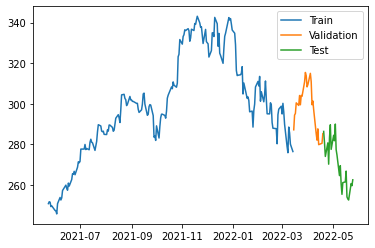

In [12]:
plt.plot(dates_train, y_train )
plt.plot(dates_val, y_val )
plt.plot(dates_test, y_test )
plt.legend(['Train', 'Validation' , 'Test'])

In [13]:
model=Sequential([layers.Input((3,1)),
                 layers.LSTM(64),
                 layers.Dense(32, activation='relu'),
                 layers.Dense(32, activation='relu'),
                 layers.Dense(1)])

2022-06-06 02:42:29.371450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-06 02:42:29.371827: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-06 02:42:29.372067: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ahmed-832): /proc/driver/nvidia/version does not exist
2022-06-06 02:42:29.373207: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model.compile(loss = 'mse',
              optimizer = Adam(learning_rate=0.001),
              metrics = ['mean_absolute_error'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 20,065
Trainable params: 20,065
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs =100)

2022-06-06 02:42:31.028239: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
7/7 [==============================] - 5s 85ms/step - loss: 90086.7266 - mean_absolute_error: 299.1323 - val_loss: 89246.6328 - val_mean_absolute_error: 298.5421
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 89932.6406 - mean_absolute_error: 298.8748 - val_loss: 89105.2031 - val_mean_absolute_error: 298.3051
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 89776.5312 - mean_absolute_error: 298.6134 - val_loss: 88906.9922 - val_mean_absolute_error: 297.9728
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 89538.9688 - mean_absolute_error: 298.2159 - val_loss: 88635.4062 - val_mean_absolute_error: 297.5167
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 89271.7969 - mean_absolute_error: 297.7664 - val_loss: 88367.7734 - val_mean_absolute_error: 297.0666
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 89002.5781 - mean_absolute_error: 297.3159 - val_loss: 88089.

7/7 [==============================] - 0s 10ms/step - loss: 606.5375 - mean_absolute_error: 19.4104 - val_loss: 119.7280 - val_mean_absolute_error: 8.9684
Epoch 49/100
7/7 [==============================] - 0s 10ms/step - loss: 606.7696 - mean_absolute_error: 19.4138 - val_loss: 119.8666 - val_mean_absolute_error: 8.9717
Epoch 50/100
7/7 [==============================] - 0s 13ms/step - loss: 606.5174 - mean_absolute_error: 19.4105 - val_loss: 119.6333 - val_mean_absolute_error: 8.9763
Epoch 51/100
7/7 [==============================] - 0s 13ms/step - loss: 606.4920 - mean_absolute_error: 19.4088 - val_loss: 119.4607 - val_mean_absolute_error: 8.9947
Epoch 52/100
7/7 [==============================] - 0s 14ms/step - loss: 606.6047 - mean_absolute_error: 19.4087 - val_loss: 119.3403 - val_mean_absolute_error: 9.0149
Epoch 53/100
7/7 [==============================] - 0s 18ms/step - loss: 606.4244 - mean_absolute_error: 19.4018 - val_loss: 119.4343 - val_mean_absolute_error: 8.9980
Epoch

Epoch 97/100
7/7 [==============================] - 0s 10ms/step - loss: 237.8596 - mean_absolute_error: 12.3040 - val_loss: 87.0000 - val_mean_absolute_error: 8.1126
Epoch 98/100
7/7 [==============================] - 0s 12ms/step - loss: 230.8520 - mean_absolute_error: 12.1158 - val_loss: 56.3104 - val_mean_absolute_error: 6.2973
Epoch 99/100
7/7 [==============================] - 0s 9ms/step - loss: 202.0324 - mean_absolute_error: 11.1931 - val_loss: 63.4783 - val_mean_absolute_error: 6.8183
Epoch 100/100
7/7 [==============================] - 0s 11ms/step - loss: 197.8562 - mean_absolute_error: 11.2943 - val_loss: 69.4987 - val_mean_absolute_error: 7.3197


In [17]:
train_predictions = model.predict(X_train).flatten()

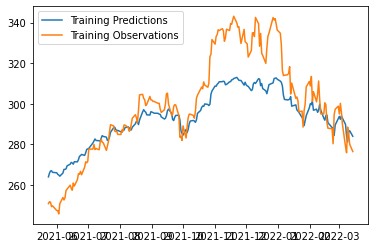

In [18]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

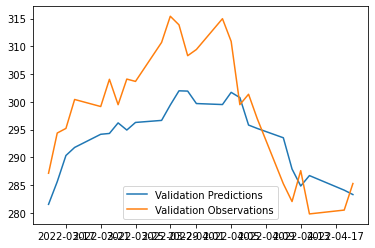

In [19]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

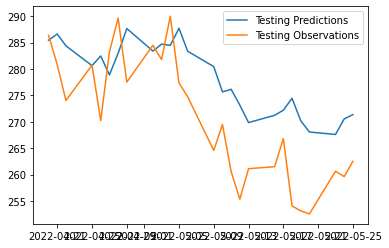

In [20]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

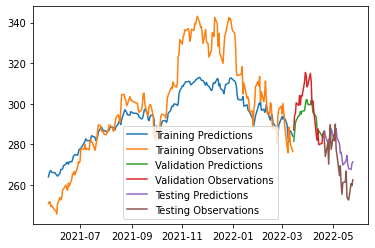

In [21]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])